In [8]:
import pandas as pd
import missingno as msno
import numpy as np
import pgeocode
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statistics
import csv
import sys
import pprint
import math
import datetime

In [9]:
# Set the datapath
DataPath='C:/Users/ragarza2/OneDrive - Source Logistics/Documents/General/Project/Capstone/Clustering Part/Data/'

In [10]:
# Import all the historic data up to today
df_velocity = pd.read_csv(DataPath + 'Historical Velocity MTBO Orders_210511.csv', skiprows = 3)
delete_velocity = pd.read_csv(DataPath + 'Delete Shipments from Velocity.csv')
df_veracore = pd.read_csv(DataPath + 'Historical Veracore MTBO Orders_210511.csv')
new_code = pd.read_csv(DataPath + 'Phase 1 Company Codes_210811.csv')

C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Clean Veracore Data

In [12]:
# Take off COSTCO work orders
df_veracore = df_veracore[~df_veracore['Product ID'].str.contains("COSTCO 15", na = False)]
searchfor = ['COSTCO', 'Costco']
df_veracore = df_veracore[~df_veracore['Order Purchase Order'].str.contains('|'.join(searchfor), na=False)]

In [13]:
# Exclude NULL Order IDs
df_veracore = df_veracore.dropna(axis=0, subset=['Order ID'])

In [14]:
# Exclude specific Product IDs
df_veracore = df_veracore[df_veracore['Product ID']!='MI5625U']

In [15]:
# Exclude rest of work orders with exceptions
df_veracore.loc[(df_veracore['Manifest ID'] == 25434),'Order Reference Number']='Exception'
searchfor = ['work', 'Work', 'WORK','W/O','w/o']
df_veracore = df_veracore[~df_veracore['Ship To-Full Name'].str.contains('|'.join(searchfor), na=False)]
df_veracore = df_veracore[~df_veracore['Order Reference Number'].str.contains('|'.join(searchfor), na=False)]

In [16]:
# Disregard City of Industry Transfers and Projects
searchfor = ['TRANSFERCOI','Project','project','PROJECT']
df_veracore = df_veracore[~df_veracore['Order Purchase Order'].str.contains('|'.join(searchfor), na=False)]
df_veracore = df_veracore[~df_veracore['Order Reference Number'].str.contains('|'.join(searchfor), na=False)]

In [17]:
# Delete all "shipments" to 90640 (Montebello) as these are not shipments but adjustments of some sort
df_veracore = df_veracore[df_veracore['Ship To-Zip/Postal Code']!='90640']

In [18]:
# Exclude Trendsformers (small account presenting data issues), drop empty column derived from it
df_veracore = df_veracore[df_veracore['Origin System Description - Pull Manifest']!='Trendsformers']
df_veracore = df_veracore.dropna(how='all', axis=1)

In [19]:
# Delete rows where zip code is zero
df_veracore = df_veracore[df_veracore['Ship To-Zip/Postal Code'].notnull()]
df_veracore = df_veracore[df_veracore['Ship To-Zip/Postal Code']!='0']

In [20]:
# Delete Purchase Orders which are inventory adjustments and sample
df_veracore = df_veracore[df_veracore['Order Purchase Order']!='INV ADJ']
searchfor = ['Samples', 'samples', 'SAMPLES']
df_veracore = df_veracore[~df_veracore['Order Purchase Order'].str.contains('|'.join(searchfor), na=False)]

In [21]:
# Convert estimated pallets to float
df_veracore['EstimatedPallets'] = df_veracore['EstimatedPallets'].astype(float)

In [22]:
# Fill zeros or blank weight cells with an approximation -> 1,200 lbs per pallet
df_veracore['TotalWeight'].fillna(df_veracore['EstimatedPallets']*1200, inplace=True)
df_veracore['TotalWeight'] = df_veracore['TotalWeight'].mask(df_veracore['TotalWeight']==0).fillna(df_veracore['EstimatedPallets']*1200)

__First Phase Changes__

In [23]:
# Delete Binnacle T-Pallet data as they are shipments originating in Laredo
df_veracore = df_veracore[~((df_veracore['Product ID'] == 'T-pallet') & 
                             (df_veracore['Origin System Description - Pull Manifest'] == 'Binnacle Logistics'))]

In [26]:
df_veracore = df_veracore.groupby(
                   ['Manifest ID']
                ).agg(
                    {
                         'Origin System ID - Pull Manifest': 'first',
                         'Origin System Description - Pull Manifest': 'first',
                         'Order ID': 'first',
                         'Order Purchase Order': 'first',
                         'Order Reference Number': 'first',
                         'Order Date': 'first',
                         'Transaction Date': 'first',
                         'Total Pieces to Pull': sum,
                         'Ship To-Full Name': 'first',
                         'Ship To-Company': 'first',
                         'Ship To-Address 1': 'first',
                         'Ship To-City': 'first',
                         'Ship To-State': 'first',
                         'Ship To-Zip/Postal Code': 'first',
                         'TotalWeight': sum,
                         'EstimatedPallets': sum,
                         'PalletWeight': sum
                         #'duration':sum,    # Sum duration per group
                         #'network_type': "count",  # get the count of networks
                         #'date': 'first'  # get the first date per group
                    }
                )


In [27]:
df_veracore['GrandTotalWeight'] = df_veracore['TotalWeight'] + df_veracore['PalletWeight']

In [28]:
# Reset index to get Manifest ID as column
df_veracore.reset_index(level=0, inplace=True)

In [30]:
# Convert date columns to date format
df_veracore['Order Date'] = pd.to_datetime(df_veracore['Order Date'])
df_veracore['Transaction Date'] = pd.to_datetime(df_veracore['Transaction Date'])

In [31]:
# Impute missing transaction values, add 5 to order date
#df_veracore[df_veracore['TransactionDate'].isna()]['TransactionDate']
df_veracore['Transaction Date'] = df_veracore['Transaction Date'].fillna(df_veracore['Order Date']+datetime.timedelta(days=5))
#df["COL3"] = df["COL1"].fillna(df["COL2"])

__Get subset of Velocity only Including Phase 1 Consolidation Companies__

In [32]:
# Only select customers that we currently have in MTBO
#searchfor = ['LW006MM','LW006','CORD084','CUSA673','CUSA673cd',
#            'CUSA673OR','NOVA463','MT5201','PCW823','PI001','MEGA655',
#            'DUI838','CDM069','BFI808','PT117','CDP875','ZP084','COI647',
#             'MTE125','CDP875','MX064','CBI092','PIF716','PIF718CLX']
searchfor = new_code['Older Code']
df_velocity = df_velocity[df_velocity['CUST_NBR'].str.contains('|'.join(searchfor), na=False, case=False)]

In [33]:
# Delete certain shipments from Velocity
delete = delete_velocity['SHIPMENT_ID']
df_velocity = df_velocity[~df_velocity['SHIPMENT_ID'].isin(delete)]

In [34]:
# Delete shipments to 90640 - MTBO as those aren't actual shipments
df_velocity = df_velocity[df_velocity['SHIP_TO_POSTAL_CODE']!='90640']

__Change old Velocity code to the new code__

In [35]:
#new_code.to_dict('records')
df_dict = new_code.drop(['Company'], axis=1)
dict_code = df_dict.set_index('Older Code').T.to_dict('list')

C:\Users\ragarza2\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# Change old velocity code to the new code
df_velocity['New Code'] = df_velocity['CUST_NBR'].str.upper().map(dict_code)
df_velocity['New Code'] = df_velocity['New Code'].str[0].astype(np.int64)
df_velocity = df_velocity.drop(['CUST_NBR'], axis = 1)
df_velocity = df_velocity.rename({'New Code': 'CUST_NBR'}, axis=1) 

In [37]:
# Drop columns that won't come to use
df_velocity.drop(columns=['SHIPMENT_ID', 'CREATE_DATE','CREATED_BY','UPDATE_DATE','UPDATED_BY','A_PRO','EXPIRATION_DATE',
                         'CUSTOMER_PO_NBR','CUSTOMER_ORDER','CARRIER','CARRIER_TRKNG_NBR','TOTAL_CASES','PALLET_QTY_1',
                         'FREIGHT_COST_1','WAITING_FEE_1'], inplace = True)

df_veracore.drop(columns=['Manifest ID', 'Order Purchase Order', 'Order Reference Number','Total Pieces to Pull',
                          'Ship To-Company', 'TotalWeight','PalletWeight'], inplace = True)

In [38]:
# Rename Veracore columns to append to Velocity columns
df_veracore.rename(columns = {'Origin System ID - Pull Manifest':'CUST_NBR',
                              'Origin System Description - Pull Manifest':'COMPANY',
                              'Order ID':'ORDER_NBR','Order Date':'ORDER_DATE', 'Transaction Date':'TRANSACTION_DATE', 
                              'Ship To-Full Name':'SHIP_TO_COMPANY','Ship To-City':'SHIP_TO_CITY',
                              'Ship To-State':'SHIP_TO_STATE','Ship To-Zip/Postal Code':'SHIP_TO_POSTAL_CODE',
                              'EstimatedPallets':'PALLET_QTY', 'GrandTotalWeight':'TOTAL_WEIGHT'}, inplace = True)

In [39]:
# Append Veracore dataset to Velocity one
df_outbound = df_velocity.append(df_veracore, ignore_index = True)

C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [40]:
df_outbound = df_outbound[['CUST_NBR', 'COMPANY', 'TRANSACTION_DATE', 'ORDER_NBR', 'ORDER_DATE', 
                           'SHIP_TO_COMPANY', 'SHIP_TO_CITY', 'SHIP_TO_STATE', 'SHIP_TO_POSTAL_CODE', 
                           'PALLET_QTY', 'TOTAL_WEIGHT']]

In [41]:
df_outbound = df_outbound[df_outbound['TOTAL_WEIGHT']>=250]

#### Feature removal:

* 'UPDATE_DATE' From Raul: The system keeps track of any up dates to the order and the up date date shows the very last one,  I do not think you need to use this for your analysis.
* 'ORDER_DATE'  Would the order date and created date be the same by definition? Could we therefore ignore one of the two columns?  
From Raul:Yes,  the only difference is that the order date can be modify by a person at the time of entry so is best to use Created date to ensure consistency.
* A_PRO This is the tracking number for the order.  (We do not use it anymore)
* EXPIRATION_DATE Date the order would expire,  this date is not always consisten and should not be use for the analysis
* PALLET_QTY_1 This needs to be ignore,  comes from the header of the report.
* FREIGHT_COST_1 This needs to be ignore,  comes from the header of the report.
* WAITING_FEE_1 This needs to be ignore,  comes from the header of the report.
* UPDATED_BY 99.9% of those is update by they system itself
* CARRIER_TRKNG_NBR Not useful

In [42]:
drop_Outbound_cols = ['ORDER_DATE']
df_outbound.drop(drop_Outbound_cols, axis=1, inplace=True)
# Change to inplace=True to affect the underlying data

#### Rename columns 
Rename some column, prepare for the table join
change CUST_NBR to CUSTOMER_ID
SHIP_TO_COMPANY keep the same
(Those are two keys to match the address table

In [43]:
df_outbound=df_outbound.rename(columns={'CUST_NBR': 'CUSTOMER_ID'})
#df_address=df_address.rename(columns={'Customer': 'CUSTOMER_ID','COMPANY':'SHIP_TO_COMPANY'})

<AxesSubplot:>

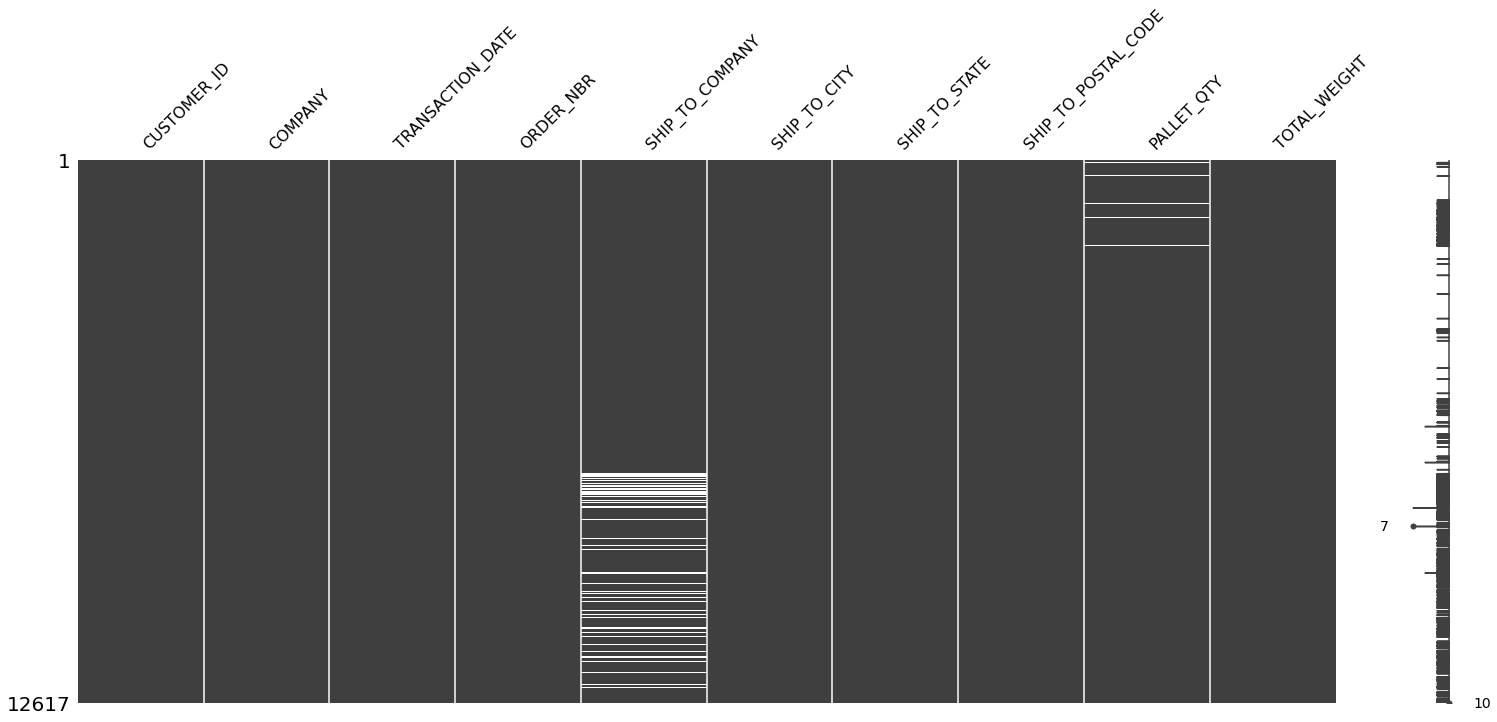

In [44]:
# Missing Data visulization
msno.matrix(df_outbound)
# It turns out most of the missing value are pallet_Qty

In [45]:
# There might still be cases that pallet qty and weight are 0, it is not nan value but 
# still quite useless, we need to take care of that by change 0 to nan value

# Set the 0 values of column 'PALLET_QTY' to np.nan
df_outbound.PALLET_QTY[df_outbound.PALLET_QTY == 0] = np.nan

# Set the 0 values of column 'TOTAL_WEIGHT' to np.nan
df_outbound.TOTAL_WEIGHT[df_outbound.TOTAL_WEIGHT == 0] = np.nan

C:\Users\ragarza2\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\ragarza2\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Remove outlier Data
* Any shipment with more than 30 pallets should be eliminated
* Any shipment with more than 45K lbs should be eliminated
* Rule:order has weight but does not have pallets then assume an average 1,200 lbs per pallet and estimate the pallets based on weight,  and then if the order has pallets and no weight assume the same 1,200 lbs per pallet to estimate the weight.

In [46]:
# Drop orders when both pallet qty and weight are missing
inds = df_outbound[["PALLET_QTY", "TOTAL_WEIGHT"]].isnull().all(axis=1) 
df_outbound = df_outbound.loc[~inds, :]

# After this procedure, we are sure that pallet qty and total weigh can be estimated 
# by using 1200lb per pallet rule

In [47]:
# Fill the empty cells for pallets and weight with zeros
df_outbound.PALLET_QTY.fillna(0, inplace=True)
df_outbound.TOTAL_WEIGHT.fillna(0, inplace=True)

In [48]:
# Delete all rows with string values instead of numbers for pallet qty and weight
df_outbound = df_outbound[np.isfinite(pd.to_numeric(df_outbound.PALLET_QTY, errors="coerce"))]
df_outbound = df_outbound[np.isfinite(pd.to_numeric(df_outbound.TOTAL_WEIGHT, errors="coerce"))]

In [49]:
# Convert pallet and weight columns to numeric
df_outbound.PALLET_QTY = pd.to_numeric(df_outbound.PALLET_QTY)
df_outbound.TOTAL_WEIGHT = pd.to_numeric(df_outbound.TOTAL_WEIGHT)

In [50]:
# Replace zeros with NAs
cols = ['PALLET_QTY','TOTAL_WEIGHT']
df_outbound[cols] = df_outbound[cols].replace({0:np.nan})

In [51]:
# Estimate weight base on pallet
df_outbound.TOTAL_WEIGHT.fillna(df_outbound.PALLET_QTY*1200, inplace=True)

In [52]:
# Estimate pallet base on weight
df_outbound.PALLET_QTY.fillna(df_outbound.TOTAL_WEIGHT/1200, inplace=True)

<AxesSubplot:>

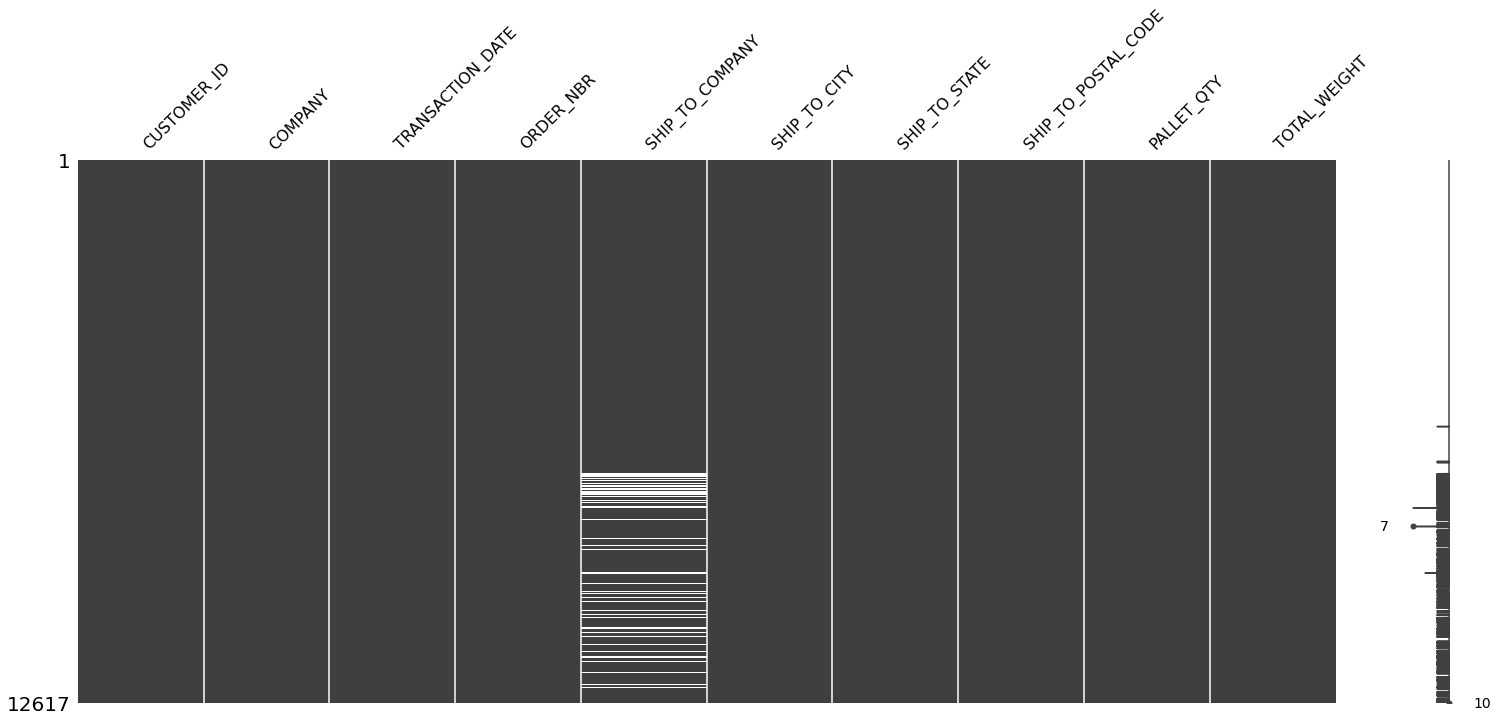

In [53]:
# As the pic shows, all the missing value for pallet and weight has been filled
msno.matrix(df_outbound)

In [54]:
# Remove outlier data
df_outbound = df_outbound[df_outbound['PALLET_QTY'] <= 30] 
df_outbound = df_outbound[df_outbound['TOTAL_WEIGHT'] <= 45000] 

In [55]:
# Round pallets to the nearest tenth, then round up, then replace zeroes with 1s.
df_outbound['PALLET_QTY'] = round(df_outbound['PALLET_QTY'],1)

In [56]:
# Create a function to round up if larger than 0 and if 0 replace with 1
def rounder(x):
    if (x > 0):
        return np.ceil(x)
    else:
        return 1

In [57]:
# Use function to round up except 0 (replace with 1)
rounder_vec = np.vectorize(rounder)
df_outbound['PALLET_QTY'] = rounder_vec(df_outbound['PALLET_QTY'])

In [58]:
# Check the data, it met our expectations
df_outbound.describe()

,CUSTOMER_ID,PALLET_QTY,TOTAL_WEIGHT
count,12518.000000,12518.00000,12518.000000
mean,104231.832961,7.53459,11242.184395
std,9246.462888,7.85419,12904.515438
min,101003.000000,1.00000,250.206800
25%,101009.000000,2.00000,1959.273475
50%,101029.000000,4.00000,5668.210000
75%,101045.000000,10.00000,15311.066667
max,132634.000000,30.00000,44943.800000


#### Missing Value Analysis
* missing completely at random (MCAR)
* missing at random (MAR)
* missing not at random (MNAR)

In [59]:
# Create a function to calculate the missing value %
def cal_missing_val(df):
    data_dict = {}  #{}means dictionary
    for col in df.columns:
        data_dict[col] = (df[col].isnull().sum()/df.shape[0])*100
    return pd.DataFrame.from_dict(data_dict, orient='index', columns=['MissingValueInPercentage'])

In [60]:
cal_missing_val(df_outbound)
# Meet the expectation

,MissingValueInPercentage
CUSTOMER_ID,0.000000
COMPANY,0.000000
TRANSACTION_DATE,0.000000
ORDER_NBR,0.000000
SHIP_TO_COMPANY,8.691484
SHIP_TO_CITY,0.015977
SHIP_TO_STATE,0.031954
SHIP_TO_POSTAL_CODE,0.000000
PALLET_QTY,0.000000
TOTAL_WEIGHT,0.000000


###### Set the time as the index and convert to datetime

In [61]:
df_outbound['TRANSACTION_DATE'] = pd.to_datetime(df_outbound['TRANSACTION_DATE'])
# set the index
#df_outbound.set_index('TRANSACTION_DATE', inplace=True)
# Filter out the data that we want
df_outbound=df_outbound[['TRANSACTION_DATE','CUSTOMER_ID','COMPANY','ORDER_NBR','SHIP_TO_POSTAL_CODE','PALLET_QTY','TOTAL_WEIGHT']]

In [62]:
df_outbound.head()

,TRANSACTION_DATE,CUSTOMER_ID,COMPANY,ORDER_NBR,SHIP_TO_POSTAL_CODE,PALLET_QTY,TOTAL_WEIGHT
0,2020-04-22,101081,Bauducco Foods Inc.,466061,90670,6.0,5998.80
1,2020-04-22,101081,Bauducco Foods Inc.,465996,93657,2.0,1298.00
2,2020-04-22,101081,Bauducco Foods Inc.,466011,850434721,2.0,2345.60
3,2020-04-23,101081,Bauducco Foods Inc.,466344,90058,2.0,2138.22
4,2020-04-23,101081,Bauducco Foods Inc.,466060,90040,13.0,13866.64


# Zip code cleaning up

In [63]:
LA_2014_2020_clean=df_outbound

In [64]:
LA_2014_2020_clean.shape

(12518, 7)

In [65]:
# change the SHIP_TO_POSTAL_CODE type from object to string
LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'] = LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'].astype('str')

In [66]:
# Remove zip code that start with letters
LA_2014_2020_clean = LA_2014_2020_clean[~LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'].str.contains("[a-zA-Z]").fillna(False)]

In [67]:
# Remove rows that is less than 4 digits
LA_2014_2020_clean['length'] = LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'].apply(lambda x: len(x))
cond = LA_2014_2020_clean['length'] >3
LA_2014_2020_clean = LA_2014_2020_clean[cond]

C:\Users\ragarza2\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
#remove everything after'-' eg.(-3793)
LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'] = LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'].str.split('-').str[0]

In [69]:
# Extract first 5 digits from a Pandas column
LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'] = LA_2014_2020_clean.SHIP_TO_POSTAL_CODE.str.extract(r'(\d{1,5})').squeeze().str.zfill(5)

In [70]:
# remove length column
LA_2014_2020_clean=LA_2014_2020_clean.drop(columns=['length'])

In [71]:
# remove Nan values in SHIP_TO_POSTAL_CODE
LA_2014_2020_clean = LA_2014_2020_clean[LA_2014_2020_clean['SHIP_TO_POSTAL_CODE'].notna()]

# Calulate distance between warehouse and destinations

In [72]:
Zipcode=LA_2014_2020_clean.SHIP_TO_POSTAL_CODE.unique()

dist = pgeocode.GeoDistance('US')

In [73]:
# Calculate the distance between LA warehouse(90640) and the destination zip code
# Store the distance into list
list=[]
LA_warehousezipcode=90640
for i in Zipcode:
    list.append(dist.query_postal_code(LA_warehousezipcode,i))
# put the distance in a dictionary
distance=dict(zip(Zipcode, list))

In [74]:
# Create the dataframe base on the dictionary
zipcode_distance_fromWarehouse=pd.DataFrame.from_dict(distance, orient='index',columns=['Distance'])

# Sepreate groups that within 50miles(80.5km), 100 miles(161km), 100-750miles(161-1207km), and beyond 750 miles(>1207km) from the warehouse



In [75]:
# For zipcodes within 50 miles of distance
zipcode_distance_Warehouse_less50m=zipcode_distance_fromWarehouse[zipcode_distance_fromWarehouse['Distance']<=80.5]

In [76]:
# For zipcodes 50-100 miles of distance
zipcode_distance_Warehouse_50_100m=zipcode_distance_fromWarehouse[zipcode_distance_fromWarehouse['Distance']>80.5]
zipcode_distance_Warehouse_50_100m=zipcode_distance_Warehouse_50_100m[zipcode_distance_Warehouse_50_100m['Distance']<=161]

In [77]:
# For zipcodes 100-750 miles of distance
zipcode_distance_Warehouse_100_750m=zipcode_distance_fromWarehouse[zipcode_distance_fromWarehouse['Distance']>161]
zipcode_distance_Warehouse_100_750m=zipcode_distance_Warehouse_100_750m[zipcode_distance_Warehouse_100_750m['Distance']<=1207]

In [78]:
# For zipcodes beyond 750 miles of distance
zipcode_distance_Warehouse_beyond750m=zipcode_distance_fromWarehouse[zipcode_distance_fromWarehouse['Distance']>1207]

In [79]:
# drop the zip code that is na
zipcode_distance_fromWarehouse=zipcode_distance_fromWarehouse.dropna()

# Within 50 mile group only clutser it as one group(Then we will delete it later)

In [80]:
zipcode_less50m=zipcode_distance_Warehouse_less50m.index.values.tolist()
# Get the latitude and longitude from zip code
nomi = pgeocode.Nominatim('US')
df_less50m = pd.DataFrame(
    [p, nomi.query_postal_code(p).latitude, nomi.query_postal_code(p).longitude] for p in zipcode_less50m
)
df_less50m=df_less50m.rename(columns={0: "zipcode", 1: "latitude",2: "longitude"})

In [81]:
#Assign Cluster number
cluster_within50m=1

In [82]:
# clustering based on latitude and longitude
kmeans = KMeans(n_clusters = cluster_within50m, init ='k-means++')
kmeans.fit(df_less50m[df_less50m.columns[1:3]]) # Compute k-means clustering.
df_less50m['cluster_label'] = kmeans.fit_predict(df_less50m[df_less50m.columns[1:3]])
centers_less50 = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df_less50m[df_less50m.columns[1:3]]) # Labels of each point

C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ragarza2\AppData\Roaming\P

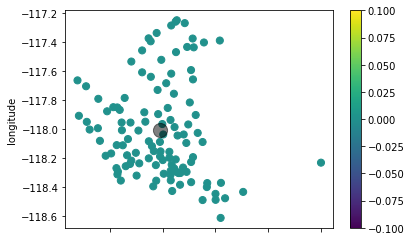

In [83]:
# Visualize the cluster
df_less50m.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers_less50[:, 0], centers_less50[:, 1], c='black', s=200, alpha=0.5)

In [84]:
# Get the cluster Centroid locations
df_centers_less50 = pd.DataFrame(data=centers_less50, columns=["Centroid_lat", "Centroid_long"])
df_centers_less50.reset_index(inplace=True)
df_centers_less50 = df_centers_less50.rename(columns = {'index':'cluster_label'})

In [85]:
# Add a column
df_less50m['distance range']='less than 50 miles from warehouse'

In [86]:
# Join df_50_100m with the centroid location data set
df_less50m = pd.merge(df_less50m, df_centers_less50, on='cluster_label', how='outer')
df_less50m.head()

,zipcode,latitude,longitude,cluster_label,distance range,Centroid_lat,Centroid_long
0,90670,33.9464,-118.0838,0,less than 50 miles from warehouse,33.989382,-118.008186
1,90058,33.9994,-118.2133,0,less than 50 miles from warehouse,33.989382,-118.008186
2,90040,33.9909,-118.1532,0,less than 50 miles from warehouse,33.989382,-118.008186
3,92618,33.7074,-117.7054,0,less than 50 miles from warehouse,33.989382,-118.008186
4,91352,34.2209,-118.3699,0,less than 50 miles from warehouse,33.989382,-118.008186


# 50-100 mile group looking for clusters of zip code that are 10 miles from each other

In [87]:
zipcode_50_100m=zipcode_distance_Warehouse_50_100m.index.values.tolist()
# Get the latitude and longitude from zip code
nomi = pgeocode.Nominatim('US')
df_50_100m = pd.DataFrame(
    [p, nomi.query_postal_code(p).latitude, nomi.query_postal_code(p).longitude] for p in zipcode_50_100m
)
df_50_100m=df_50_100m.rename(columns={0: "zipcode", 1: "latitude",2: "longitude"})

In [108]:
#Assign Cluster number
cluster_50_100m=8

In [109]:
# clustering based on latitude and longitude
kmeans = KMeans(n_clusters = cluster_50_100m, init ='k-means++')
kmeans.fit(df_50_100m[df_50_100m.columns[1:3]]) # Compute k-means clustering.
df_50_100m['cluster_label'] = kmeans.fit_predict(df_50_100m[df_50_100m.columns[1:3]])
centers_50_100 = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df_50_100m[df_50_100m.columns[1:3]]) # Labels of each point

C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ragarza2\AppData\Roaming\P

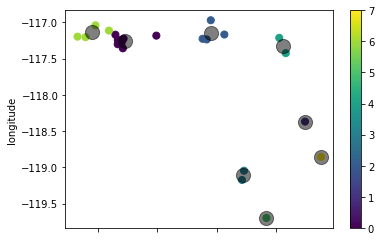

In [110]:
# Visualize the cluster
df_50_100m.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers_50_100[:, 0], centers_50_100[:, 1], c='black', s=200, alpha=0.5)

In [111]:
# Get the cluster Centroid locations
df_centers_50_100 = pd.DataFrame(data=centers_50_100, columns=["Centroid_lat", "Centroid_long"])
df_centers_50_100.reset_index(inplace=True)
df_centers_50_100 = df_centers_50_100.rename(columns = {'index':'cluster_label'})

In [112]:
# the loop through zipcode within clusters, find the max distance and check if its reasonable, if not, 
#we change the number of cluster and rerun the process
list_Max_cluster=[]
for c in range(cluster_50_100m):
    list=[]
    for i in df_50_100m[df_50_100m['cluster_label']==c]['zipcode'].to_list():
        for s in df_50_100m[df_50_100m['cluster_label']==c]['zipcode'].to_list():
            list.append(dist.query_postal_code(i,s))
    list_Max_cluster.append(max(list))
# Transfer back from KM to mile
# The average distance of the within clusters
statistics.mean(list_Max_cluster)/1.6

9.852438796369235

In [113]:
# Add a column
df_50_100m['distance range']='50 to 100 miles from warehouse'

In [114]:
# Join df_50_100m with the centroid location data set
df_50_100m = pd.merge(df_50_100m, df_centers_50_100, on='cluster_label', how='outer')
df_50_100m.head()

,zipcode,latitude,longitude,cluster_label,distance range,Centroid_lat,Centroid_long
0,93243,34.8818,-118.8566,7,50 to 100 miles from warehouse,34.8818,-118.8566
1,93030,34.2141,-119.1750,3,50 to 100 miles from warehouse,34.2227,-119.1107
2,93010,34.2313,-119.0464,3,50 to 100 miles from warehouse,34.2227,-119.1107
3,92307,34.5291,-117.2132,4,50 to 100 miles from warehouse,34.5566,-117.3187
4,92301,34.5841,-117.4242,4,50 to 100 miles from warehouse,34.5566,-117.3187


# 100-750 mile group looking for clusters of zip code that are 50 miles from each other

In [115]:
zipcode_100_750m=zipcode_distance_Warehouse_100_750m.index.values.tolist()
# Get the latitude and longitude from zip code
df_100_750m = pd.DataFrame(
    [p, nomi.query_postal_code(p).latitude, nomi.query_postal_code(p).longitude] for p in zipcode_100_750m
)
df_100_750m=df_100_750m.rename(columns={0: "zipcode", 1: "latitude",2: "longitude"})

In [124]:
#Assign Cluster number
cluster_100_750m=23

In [125]:
# clustering based on latitude and longitude
kmeans = KMeans(n_clusters = cluster_100_750m, init ='k-means++')
kmeans.fit(df_100_750m[df_100_750m.columns[1:3]]) # Compute k-means clustering.
df_100_750m['cluster_label'] = kmeans.fit_predict(df_100_750m[df_100_750m.columns[1:3]])
centers_100_750 = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df_100_750m[df_100_750m.columns[1:3]]) # Labels of each point

C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ragarza2\AppData\Roaming\P

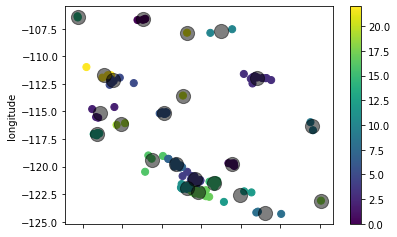

In [126]:
# Visualize the cluster
df_100_750m.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers_100_750[:, 0], centers_100_750[:, 1], c='black', s=200, alpha=0.5)

In [127]:
# Get the cluster Centroid locations
df_centers_100_750 = pd.DataFrame(data=centers_100_750, columns=["Centroid_lat", "Centroid_long"])
df_centers_100_750.reset_index(inplace=True)
df_centers_100_750 = df_centers_100_750.rename(columns = {'index':'cluster_label'})

In [128]:
# the loop through zipcode within clusters, find the max distance and check if its reasonable, if not, 
#we change the number of cluster and rerun the process
list_Max_cluster=[]
for c in range(cluster_100_750m):
    list=[]
    for i in df_100_750m[df_100_750m['cluster_label']==c]['zipcode'].to_list():
        for s in df_100_750m[df_100_750m['cluster_label']==c]['zipcode'].to_list():
            list.append(dist.query_postal_code(i,s))
    list_Max_cluster.append(max(list))
# Transfer back from KM to mile
# The average distance of the within clusters
statistics.mean(list_Max_cluster)/1.6

52.24524000970229

In [129]:
# Add a column
df_100_750m['distance range']='100 to 750 miles from warehouse'

In [130]:
# Join df_100_750m with the centroid location data set
df_100_750m = pd.merge(df_100_750m, df_centers_100_750, on='cluster_label', how='outer')
df_100_750m.head()

,zipcode,latitude,longitude,cluster_label,distance range,Centroid_lat,Centroid_long
0,93657,36.7243,-119.5478,7,100 to 750 miles from warehouse,36.727269,-119.763862
1,93725,36.6207,-119.7308,7,100 to 750 miles from warehouse,36.727269,-119.763862
2,93292,36.3302,-119.2921,7,100 to 750 miles from warehouse,36.727269,-119.763862
3,93721,36.7377,-119.7843,7,100 to 750 miles from warehouse,36.727269,-119.763862
4,93638,37.0402,-120.0335,7,100 to 750 miles from warehouse,36.727269,-119.763862


# Beyond 750 mile group looking for clusters of zip code that are 100 miles from each other

In [131]:
zipcode_beyond_750m=zipcode_distance_Warehouse_beyond750m.index.values.tolist()
# Get the latitude and longitude from zip code
df_beyond_750m = pd.DataFrame(
    [p, nomi.query_postal_code(p).latitude, nomi.query_postal_code(p).longitude] for p in zipcode_beyond_750m
)
df_beyond_750m=df_beyond_750m.rename(columns={0: "zipcode", 1: "latitude",2: "longitude"})

In [137]:
#Assign Cluster number
cluster_beyond_750m=35

In [138]:
# clustering based on latitude and longitude
kmeans = KMeans(n_clusters = cluster_beyond_750m, init ='k-means++')
kmeans.fit(df_beyond_750m[df_beyond_750m.columns[1:3]]) # Compute k-means clustering.
df_beyond_750m['cluster_label'] = kmeans.fit_predict(df_beyond_750m[df_beyond_750m.columns[1:3]])
centers_beyond_750 = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df_beyond_750m[df_beyond_750m.columns[1:3]]) # Labels of each point

C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ragarza2\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ragarza2\AppData\Roaming\P

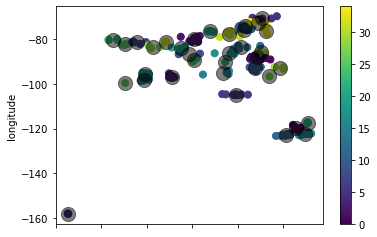

In [139]:
# Visualize the cluster
df_beyond_750m.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers_beyond_750[:, 0], centers_beyond_750[:, 1], c='black', s=200, alpha=0.5)

In [140]:
# Get the cluster Centroid locations
df_centers_beyond_750 = pd.DataFrame(data=centers_beyond_750, columns=["Centroid_lat", "Centroid_long"])
df_centers_beyond_750.reset_index(inplace=True)
df_centers_beyond_750 = df_centers_beyond_750.rename(columns = {'index':'cluster_label'})

In [141]:
# the loop through zipcode within clusters, find the max distance and check if its reasonable, if not, 
#we change the number of cluster and rerun the process
list_Max_cluster=[]
for c in range(cluster_beyond_750m):
    list=[]
    for i in df_beyond_750m[df_beyond_750m['cluster_label']==c]['zipcode'].to_list():
        for s in df_beyond_750m[df_beyond_750m['cluster_label']==c]['zipcode'].to_list():
            list.append(dist.query_postal_code(i,s))
    list_Max_cluster.append(max(list))
# Transfer back from KM to mile
# The average distance of the within clusters
statistics.mean(list_Max_cluster)/1.6

103.25282799945876

In [142]:
# Add a column
df_beyond_750m['distance range']='beyond 750 miles from warehouse'

In [143]:
# Join df_beyond_750m with the centroid location data set
df_beyond_750m = pd.merge(df_beyond_750m, df_centers_beyond_750, on='cluster_label', how='outer')
df_beyond_750m.head()

,zipcode,latitude,longitude,cluster_label,distance range,Centroid_lat,Centroid_long
0,98903,46.5445,-120.7444,0,beyond 750 miles from warehouse,46.42093,-119.82813
1,98930,46.2538,-119.9157,0,beyond 750 miles from warehouse,46.42093,-119.82813
2,98953,46.4158,-120.2662,0,beyond 750 miles from warehouse,46.42093,-119.82813
3,98902,46.5934,-120.5311,0,beyond 750 miles from warehouse,46.42093,-119.82813
4,99301,46.2492,-119.1044,0,beyond 750 miles from warehouse,46.42093,-119.82813


Join the cluster back to dataset

In [144]:
# Rename zipcode to SHIP_TO_POSTAL_CODE, prepare for join the cluster back to the dataset
df_less50m.rename(columns={'zipcode':'SHIP_TO_POSTAL_CODE'}, inplace=True)
df_50_100m.rename(columns={'zipcode':'SHIP_TO_POSTAL_CODE'}, inplace=True)
df_100_750m.rename(columns={'zipcode':'SHIP_TO_POSTAL_CODE'}, inplace=True)
df_beyond_750m.rename(columns={'zipcode':'SHIP_TO_POSTAL_CODE'}, inplace=True)

In [145]:
# change the cluster number
df_50_100m['cluster_label']=df_50_100m['cluster_label']+cluster_within50m
df_100_750m['cluster_label']=df_100_750m['cluster_label']+cluster_within50m+cluster_50_100m
# change the cluster number on df_beyond_750m+cluster_within100m+cluster_100_750m
df_beyond_750m['cluster_label']=df_beyond_750m['cluster_label']+cluster_within50m+cluster_50_100m+cluster_100_750m

# Now Join the table together so that cluster will be part of the dataframe

In [146]:
cluster=pd.concat([df_less50m,df_50_100m, df_100_750m,df_beyond_750m])
LA_2014_2020_Cluster = pd.merge(LA_2014_2020_clean, cluster, on='SHIP_TO_POSTAL_CODE', how='outer')

In [147]:
# # drop the zip code that is na
LA_2014_2020_Cluster=LA_2014_2020_Cluster.dropna()

# The cluster within 50 miles is 0

In [148]:
LA_2014_2020_Cluster.shape

(12365, 13)

In [149]:
# Export the result to CSV
LA_2014_2020_Cluster.to_csv('LA_2020_2021_zipcodeCluster_Final.csv')
cluster.to_csv('LA_2020_2021_zipcode_Dictionary.csv')

# Analyze Certain Clusters

In [150]:
LA_2014_2020_Cluster

,TRANSACTION_DATE,CUSTOMER_ID,COMPANY,ORDER_NBR,SHIP_TO_POSTAL_CODE,PALLET_QTY,TOTAL_WEIGHT,latitude,longitude,cluster_label,distance range,Centroid_lat,Centroid_long
0,2020-04-22,101081,Bauducco Foods Inc.,466061,90670,6.0,5998.800000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
1,2020-04-28,101081,Bauducco Foods Inc.,466437,90670,8.0,8970.240000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
2,2020-05-01,101081,Bauducco Foods Inc.,466842,90670,1.0,1032.600000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
3,2020-05-05,101081,Bauducco Foods Inc.,466479,90670,3.0,2912.800000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
4,2020-05-18,101081,Bauducco Foods Inc.,468300,90670,4.0,4691.200000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
5,2020-05-29,101081,Bauducco Foods Inc.,468982,90670,2.0,1133.540000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
6,2020-06-12,101081,Bauducco Foods Inc.,470402,90670,5.0,5842.680000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
7,2020-06-24,101081,Bauducco Foods Inc.,471719,90670,8.0,9382.400000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
8,2020-07-13,101081,Bauducco Foods Inc.,473567,90670,4.0,4691.200000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186
9,2020-08-06,101081,Bauducco Foods Inc.,477083,90670,5.0,5864.000000,33.9464,-118.0838,0.0,less than 50 miles from warehouse,33.989382,-118.008186


In [179]:
# Clusters to start consolidation on

clust_13_24 = LA_2014_2020_Cluster.where(LA_2014_2020_Cluster['cluster_label'].isin(['13.0','24.0'])).dropna(subset = ['COMPANY'])
clust_13_24.drop(columns=['CUSTOMER_ID','ORDER_NBR','SHIP_TO_POSTAL_CODE','latitude',
                         'longitude','cluster_label','distance range','Centroid_lat','Centroid_long'], inplace = True)

clust_13_24 = clust_13_24.where(clust_13_24['TRANSACTION_DATE']>'2021-04-10').dropna()

,TRANSACTION_DATE,COMPANY,PALLET_QTY,TOTAL_WEIGHT
2160,2021-04-23,"Mexilink, Incorporated",7.0,13615.000000
2198,2021-04-17,Bauducco Foods Inc,2.0,2426.000000
2199,2021-04-21,Deoleo - California,4.0,5619.340000
2200,2021-04-27,Deoleo - California,4.0,5719.680000
2201,2021-04-30,Bauducco Foods Inc,2.0,2425.600000
2260,2021-04-20,"Mexilink, Incorporated",4.0,5351.277626
2297,2021-04-28,CAB Enterprises Inc.- Laboratorios Pisa,15.0,24165.500000
2298,2021-04-29,CAB Enterprises Inc.- Laboratorios Pisa,21.0,33864.000000
2355,2021-04-11,Market 5201 - California,1.0,1347.900000
2356,2021-04-22,Novamex - California,1.0,724.350000


In [180]:
cust_13_24 = clust_13_24.groupby(
                   ['COMPANY']
                ).agg(
                    {
                         'PALLET_QTY': sum,
                         'TOTAL_WEIGHT': sum
                    }
                )
cust_13_24

,PALLET_QTY,TOTAL_WEIGHT
COMPANY,,
Bauducco Foods Inc,17.0,17814.72000
C2O - California,48.0,110049.15000
CAB Enterprises Inc.- Laboratorios Pisa,321.0,515465.50000
Cordialsa USA - California,122.0,174585.19400
Deoleo - California,92.0,177252.04000
Earthrated - California,7.0,6135.55855
Lucas World - California,21.0,16715.26000
Market 5201 - California,3.0,4299.90000
Mega Alimentos - California,5.0,10100.12000
